# Viewing images of Varchamp wells
**Author:** Jessica Ewald <br>

The purpose of this script is to query image names by batch, plate, well, site, & channel, download from AWS, and render in a notebook. This will be useful for quick visual sanity checks.

In [3]:
# Imports
import polars as pl
import numpy as np
from sh import aws
import os
from skimage.io import imread
from matplotlib import pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [4]:
# get sample metadata
dat = pl.scan_parquet("/dgx1nas1/storage/data/jess/varchamp/sc_data/processed_profiles/Rep_Ctrls/annotated_normalized_featselected.parquet")

meta_cols = [i for i in dat.columns if "Metadata_" in i]

dat = dat.select(meta_cols).collect()

In [ ]:
# Define mapping between simple names and folder names
batch_dict = {"B4A3R1": "2023-12-15_B4A3R1",
              "B6A3R2": "2023-12-21_B6A3R2"}

letter_dict = {"A":"01", "B":"02", "C":"03", "D":"04", "E":"05", "F":"06", "G":"07", "H":"08", "I":"09", "J":"10", "K":"11", "L":"12", "M":"13", "N":"14", "O":"15", "P":"16"}

plate_dict = {"T1": "2023-12-15_B4A3R1_P1T1__2023-12-15T08_49_02-Measurement1",
              "T2": "2023-12-15_B4A3R1_P1T2__2023-12-15T10_35_54-Measurement1",
              "T3": "2023-12-18_B4A3R1_P1T3__2023-12-18T08_29_45-Measurement1",
              "T4": "2023-12-18_B4A3R1_P1T4__2023-12-18T10_17_07-Measurement1"}

channel_dict_T1T2 = {"DAPI":"2", "GFP":"1", "Mito":"3", "AGP":"4", "Brightfield1":"5", "Brightfield2":"6", "Brightfield":"7"}
channel_dict_T3T4 = {"DAPI":"1", "GFP":"2", "Mito":"3", "AGP":"4", "Brightfield1":"5", "Brightfield2":"6", "Brightfield":"7"}

In [19]:
# Specify image parameters

sel_batch = "B4A3R1"
sel_plate = "T3"
site = "06"
well = "A20"
sel_channel = "GFP"

In [20]:
# construct image name and aws path
letter = well[0]
col = well[1:3]
batch = batch_dict[sel_batch]
row = letter_dict[letter]
plate = plate_dict[sel_plate]

if sel_plate in ["T1", "T2"]:
    channel = channel_dict_T1T2[sel_channel]
else:
    channel = channel_dict_T3T4[sel_channel]

img_nm = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"

aws_path = f"s3://cellpainting-gallery/cpg0020-varchamp/broad/images/{batch}/images/{plate}/Images/{img_nm}"
dgx_path = f"/dgx1nas1/storage/data/jess/varchamp/images/{sel_batch}/{sel_plate}"

In [21]:
# construct folder path in DGX
os.makedirs(dgx_path, exist_ok=True) 

# download image if it doesn't already exist
if os.path.isfile(f"{dgx_path}/{img_nm}"):
    print("file exists!")
else:
    aws("s3",
        "cp",
        aws_path, 
        f"{dgx_path}/{img_nm}")
    print("downloaded file!")


file exists!


In [22]:
# read tiff into numpy array
img = imread(f"{dgx_path}/{img_nm}", as_gray=True)
img.max()

25694

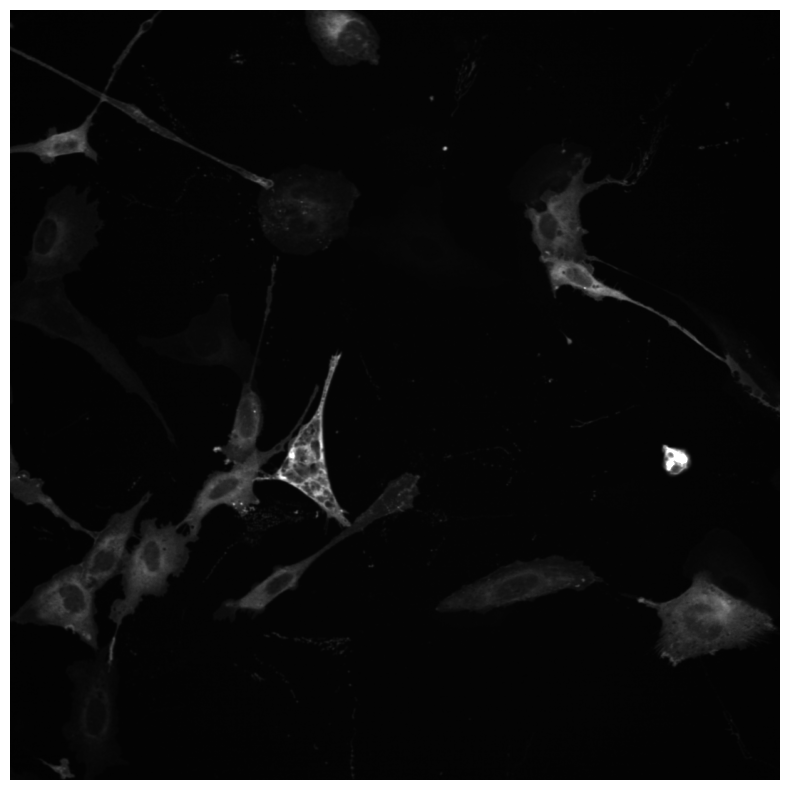

In [23]:

plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray", vmin=0, vmax=10000)
plt.axis('off')
plt.show()